In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

def time_series_lagger(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(df.shape[1])]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(df.shape[1])]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(df.shape[1])]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Train-Test-Split
def train_test_split(data, test_set_len):
    return data[:-test_set_len, :], data[-test_set_len:, :]

# --------------------- NEW -----------------------------------------------------------------------------------
# CNN Model
def cnn_initial(train):
    train_ = np.asarray(train)
    X_train, y_train = train_[:, :-1], train_[:, -1]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    window_size = X_train.shape[1]
    current_model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    current_model.compile(optimizer='adam', loss='mse')
    current_model.fit(X_train, y_train, epochs=200, verbose=0)
    return current_model
#--------------------------------------------------------------------------------------------------------------


# functions for synthetic data generation
def generate_seasonal_component(t, amplitude, frequency, shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + shift* np.pi)

def generate_trend_component(t, slope, curvature_quadratic, curvature_cubic):
    return slope * t + curvature_quadratic * t**2 + curvature_cubic * t**3

def generate_autoregressive_component(t, ar_coefficients):
    ar_data = np.zeros_like(t)
    for i in range(len(ar_coefficients)):
        if i == 0:
            continue
        ar_data[i] = np.sum(ar_data[:i] * ar_coefficients[:i]) + np.random.randn()
    return ar_data

def generate_noise(noise_level):
    return np.round(noise_level * np.random.randn(len(t)),4)

def generate_synthetic_time_series(t, amplitude, frequency, slope, shift, offset,
                                   curvature_quadratic, curvature_cubic, ar_coefficients=None):
    seasonal_component = generate_seasonal_component(t, amplitude, frequency, shift)
    trend_component = generate_trend_component(t, slope, curvature_quadratic, curvature_cubic)

    if ar_coefficients is not None:
        ar_data = generate_autoregressive_component(t, ar_coefficients)
    else:
        ar_data = np.zeros_like(t)

    synthetic_data_ = offset + seasonal_component + trend_component + ar_data
    return np.round(synthetic_data_, 4)




#Create synthetic data



In [4]:
# SET INITIAL PARAMETERS
t = np.linspace(0, 30, 90)
amplitude = 2.0
shift = 0
offset = 0
frequency = 0.1
slope = 0.1
curvature_quadratic = 0.0
curvature_cubic = 0
noise_level = 0.5
ar_coefficients = None
#amplitude, or frequency could have irregularities to.

# CREATE INITIAL TIME SERIES
synthetic_data = generate_synthetic_time_series(t, amplitude, frequency, slope, shift, offset, curvature_quadratic,
                                                 curvature_cubic, ar_coefficients=None)
default_noise = generate_noise(noise_level)

synthetic_data = pd.Series(synthetic_data + default_noise)
synthetic_data.round(decimals=4)

0     0.2661
1     0.7556
2     1.4430
3     0.8843
4     1.7441
       ...  
85    1.2093
86    1.8646
87    1.9010
88    2.1377
89    3.2604
Length: 90, dtype: float64

#Prepare data and train CNN

In [5]:
#create linear function
#values = np.arange(1, 91).reshape(-1, 1)

test_set_len = 30

#--------------------- NEW -----------------------------------------------------------------------------------
values = synthetic_data.values.reshape(-1,1)

# Normalize data for CNN
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

# --------------------------------------------------------------------------------------------------------

# Create Lagged DataFrame
window_size = 5
lagged_data = time_series_lagger(values_scaled, n_in=window_size, n_out=1)

# Train-Test-Split
train_data, test_data = train_test_split(lagged_data.values, test_set_len)

# Train CNN Modell with Train_data
current_model = cnn_initial(train_data)

# Prepare Test_data
test_ = np.asarray(test_data)
X_test, y_test = test_[:, :-1], test_[:, -1]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



#Predict one point

[[0.35159588]
 [0.41874252]
 [0.53013616]
 [0.62418876]
 [0.64837455]]
1/1 [==============================] - 0s 12ms/step
Vorhergesagter Wert für den nächsten Punkt: 2.7957757
Tatsächlicher Wert für den nächsten Punkt: 1.9468


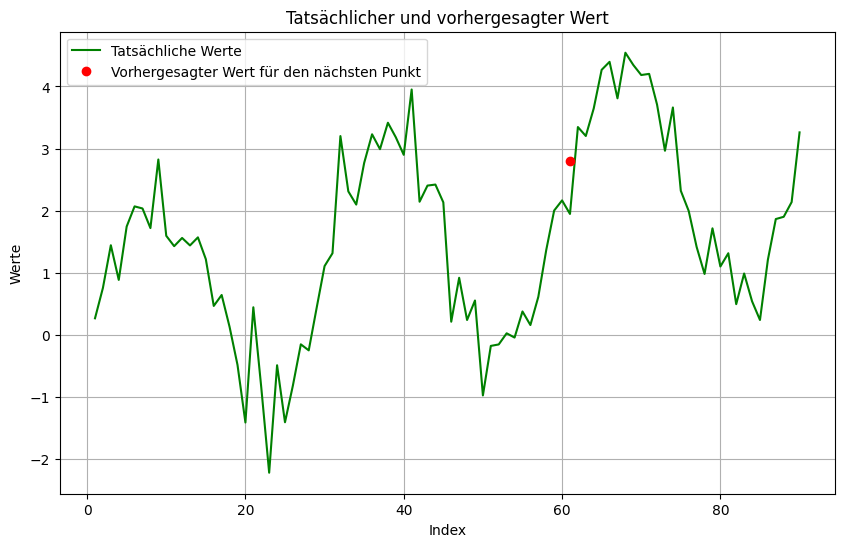

In [18]:
# Prediction for Point 61
last_window = values_scaled[55:60]
print(last_window)
last_window_reshaped = last_window.reshape((1, window_size, 1))
predicted_value = current_model.predict(last_window_reshaped)

# Rescale predicted value
predicted_value = scaler.inverse_transform(predicted_value)
print("Vorhergesagter Wert für den nächsten Punkt:", predicted_value[0][0])

# Actual value for point 61
actual_value = values[-test_set_len][0]
print("Tatsächlicher Wert für den nächsten Punkt:", actual_value)

# Plot of acutal and predicted values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 91), values, 'g-', label='Tatsächliche Werte')
plt.plot(61, predicted_value[0][0], 'ro', label='Vorhergesagter Wert für den nächsten Punkt')
plt.xlabel('Index')
plt.ylabel('Werte')
plt.title('Tatsächlicher und vorhergesagter Wert')
plt.legend()
plt.grid(True)
plt.show()

#Predict multiple points

1/1 [==============================] - 0s 13ms/step
last_window: 
[[[0.35159588]
  [0.41874252]
  [0.53013616]
  [0.62418876]
  [0.64837455]]]
prediction: [[0.74164003]]
1/1 [==============================] - 0s 11ms/step
last_window: 
[[[0.41874252]
  [0.53013616]
  [0.62418876]
  [0.64837455]
  [0.74164003]]]
prediction: [[0.78984135]]
1/1 [==============================] - 0s 12ms/step
last_window: 
[[[0.53013616]
  [0.62418876]
  [0.64837455]
  [0.74164003]
  [0.78984135]]]
prediction: [[0.7881028]]
1/1 [==============================] - 0s 11ms/step
last_window: 
[[[0.62418876]
  [0.64837455]
  [0.74164003]
  [0.78984135]
  [0.78810281]]]
prediction: [[0.7830801]]
1/1 [==============================] - 0s 11ms/step
last_window: 
[[[0.64837455]
  [0.74164003]
  [0.78984135]
  [0.78810281]
  [0.7830801 ]]]
prediction: [[0.80376834]]
1/1 [==============================] - 0s 11ms/step
last_window: 
[[[0.74164003]
  [0.78984135]
  [0.78810281]
  [0.7830801 ]
  [0.80376834]]]
predictio

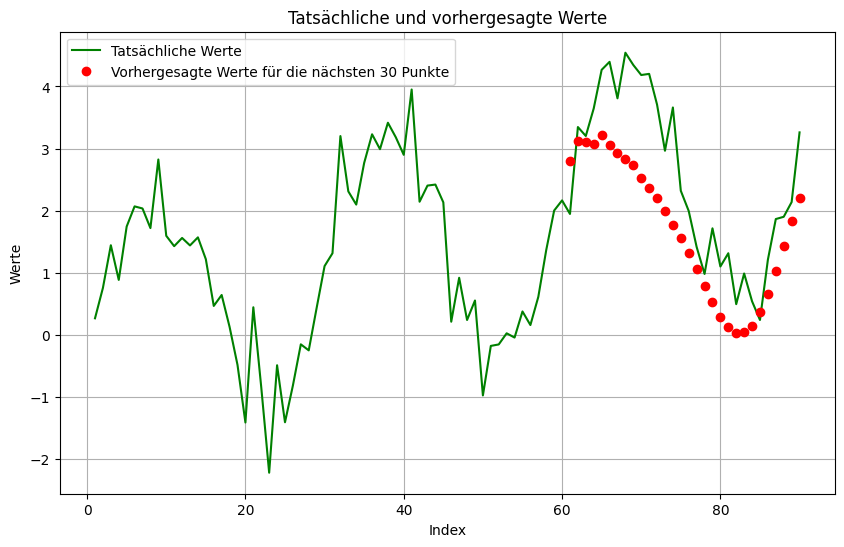

Vorhergesagte Werte für die nächsten 30 Punkte: [2.7957757  3.121824   3.1100638  3.076089   3.2160304  3.0645416
 2.9223971  2.8383918  2.7322307  2.5195255  2.3675551  2.197171
 1.9991823  1.7665788  1.5587105  1.3197484  1.0650083  0.79105884
 0.53622293 0.29436874 0.12617746 0.033242   0.04339437 0.14495595
 0.36345267 0.65525085 1.0243413  1.4256938  1.8367614  2.1974247 ]
Tatsächliche Werte für die nächsten 30 Punkte: [1.9468 3.3463 3.2024 3.6463 4.2678 4.3967 3.8087 4.5434 4.3458 4.1842
 4.2027 3.7074 2.9643 3.6615 2.3199 1.9941 1.4152 0.9803 1.7154 1.1004
 1.3139 0.4938 0.9877 0.5404 0.2391 1.2093 1.8646 1.901  2.1377 3.2604]


In [9]:
# Letztes Fenster für die Vorhersage vorbereiten
last_window = values_scaled[55:60].reshape((1, window_size, 1))

# Vorhersage der nächsten 30 Datenpunkte
predictions = []
for _ in range(test_set_len):
    predicted_value = current_model.predict(last_window)
    predictions.append(predicted_value[0][0])
    print("last_window: ")
    print(last_window)
    last_window = np.append(last_window[:, 1:, :], predicted_value.reshape((1, 1, 1)), axis=1)
    print("prediction: "+ str(predicted_value))

# Vorhersagen in den ursprünglichen Wertebereich zurückskalieren
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Tatsächliche Werte für die nächsten 30 Punkte
actual_values = values[-test_set_len:]

# Plot der tatsächlichen und vorhergesagten Werte
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 91), values, 'g-', label='Tatsächliche Werte')
plt.plot(np.arange(61, 91), predictions, 'ro', label='Vorhergesagte Werte für die nächsten 30 Punkte')
plt.xlabel('Index')
plt.ylabel('Werte')
plt.title('Tatsächliche und vorhergesagte Werte')
plt.legend()
plt.grid(True)
plt.show()

print("Vorhergesagte Werte für die nächsten 30 Punkte:", predictions.flatten())
print("Tatsächliche Werte für die nächsten 30 Punkte:", actual_values.flatten())